<a href="https://colab.research.google.com/github/Kratosgado/audio-steganography/blob/main/steg_ai/core_modules/Final_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install stable-baselines3 shimmy --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal
from scipy.signal import get_window
from scipy.fft import dct, idct
import scipy.io.wavfile as wf
import scipy
import requests
import torch.nn.functional as F
from collections import deque
import gym
from gym import spaces
import random
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [ ]:
# warnings.filterwarnings("ignore")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# --- UTILITY FUNCTIONS ---

In [ ]:
def download_file(url, local_filename): # gemini
  """Downloads a file if it doesn't already exist."""
  if not os.path.exists(local_filename):
    print(f"Downloading {local_filename}...")
    with requests.get(url, stream=True) as r:
      r.raise_for_status()
      with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
          f.write(chunk)
    print(f"{local_filename} downloaded successfully.")
  else:
    print(f"{local_filename} already exists.")

NORM_NUM = 32768

# --- HYPERPARAMETERS ---

In [ ]:
class Config: # gemini
  """Class to hold all hyperparameters."""
  #Audio processing
  FRAME_SIZE = 1024 #2048
  HOP_LENGTH = 256 #512
  NON_CRITICAL_PERCENT = 0.1 # Modify bottom 10% of coeffs by magnitude
  STATE_DIM = 1024
  SAMPLE_RATE = 22050
  N_MELS = 128

  # RL Training
  EPISODES = 1000
  LEARNING_RATE_ACTOR = 3e-4
  LEARNING_RATE_CRITIC = 3e-4
  GAMMA = 0.99 # Discount factor
  GAE_LAMBDA = 0.95 # Lambda for Generalized Advantage Estimation
  PPO_EPSILON = 0.2 # Epsilon for clipping in PPO
  PPO_EPOCHS = 10 # Number of epochs for PPO update
  BATCH_SIZE = 64

  # Environment Network Pre-training
  PRETRAIN_EPOCHS = 10
  PRE_TRAIN_LR = 1e-3
  PRE_TRAIN_BATCH_SIZE = 32

  # Reward weights
  SNR_WEIGHTS = 0.02 # Weight for SNR in reward. Tuned to be on a similar scale to detection prob.
  DETECTION_WEIGHT = 1.0 # Weight for detection probability in reward.
  IMPERCEPTIBILITY_WEIGHT = 0.3
  UNDETECTABILITY_WEIGHT = 0.4
  EXTRACTION_ACCURACY_WEIGHT = 0.3

# --- MODULE 1: AUDIO PREPROCESSOR ---

In [ ]:
class AudioPreprocessor:
  """Handles audio loading, MDCT, and inverse MDCT."""
  def __init__(self, audio_path= None, audio_data=None, frame_size = FRAME_SIZE, hop_length=HOP_LENGTH, sr=SAMPLE_RATE):
    if audio_path:
      self.audio, self.sr = librosa.load(audio_path, sr=sr, mono=True)
    elif audio_data is not None:
      self.audio = audio_data
      self.sr = sr
    else:
      raise ValueError("Either audio_path or audio_data must be provided")

    # Normalize audio
    self.audio = self.audio / np.max(np.abs(self.audio))
    self.frame_size = frame_size
    self.hop_length = hop_length
    self.window = get_window('hann', self.frame_size)
    # return self.audio, self.sr

  def load_audio(self, path):
    """Load WAV audio file"""
    audio, _ = librosa.load(path, sr=self.sr)
    return audio

  def stft(self, audio):
    """Compute Short-Time Fourier Transform (STFT)"""
    return librosa.stft(audio, n_fft=self.frame_size, hop_length=self.hop_length)

  def istft(self, stft_matrix):
    """Compute Inverse Short-Time Fourier Transform (ISTFT)"""
    return librosa.istft(stft_matrix, hop_length=self.hop_length)

  def compute_mdct(self):
    """Compute Modified Discrete Cosine Transform (MDCT) using STFT and DCT from librosa"""
    stft = self.stft(self.audio)
    magnitudes = np.abs(stft)
    phases = np.angle(stft)
    return magnitudes, phases

  def inverse_qmdct(self, qmdct_coeffs: np.ndarray) -> np.ndarray:
    pass

  def get_non_critical_coeffs(self, magnitudes, percentile=10):
    """Identify non-critical coefficients (lowest magnitude)"""
    threshold = np.percentile(np.abs(magnitudes.flatten()), percentile)
    mask = np.abs(magnitudes) < threshold
    return mask

  def reconstruct_audio(self, magnitudes, phases):
    """Reconstruct audio from magnitude/stft matrix and phase/non_critical_coeffs"""
    stft = magnitudes * np.exp(1j * phases)
    reconstructed_audio = self.istft(stft)
    return reconstructed_audio

  def plot_spectrogram(self, title):
    """Visualize audio spectrogram"""
    plt.figure(figsize=(10, 4))
    S = librosa.amplitude_to_db(np.abs(librosa.stft(self.audio)), ref=np.max)
    librosa.display.specshow(S, sr=self.sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

  def save_audio(self, audio: np.ndarray, path: str):
    wf.write(path,22050, (audio * NORM_NUM).astype(np.int16))

# --- MODULE 2: RL ACTOR-CRITIC NETWORKS ---

In [ ]:
class PolicyNetwork(nn.Module):
  """Actor Network: Decides on the modification scale."""
  def __init__(self, input_dim, hidden_dim=256):
    super(PolicyNetwork, self).__init__()
    self.fc = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU()
    )
    self.mean_layer = nn.Linear(hidden_dim, 1)
    self.log_std_layer = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    features = self.fc(x)
    mean = self.mean_layer(features)
    log_std = self.log_std_layer(features)
    log_std = torch.clamp(log_std, min=-20, max=2)  # Constrain for stability
    return mean, log_std

  def sample_action(self, state):
    """Sample action from policy distribution"""
    state_tensor = torch.as_tensor(state, dtype=torch.float32).to(DEVICE)
    mean, log_std = self.forward(state_tensor)
    std = torch.exp(log_std)
    normal_dist = torch.distributions.Normal(mean, std)
    action = normal_dist.sample()
    return action.cpu().detach().numpy().flatten()

# 7. Feature Extractor for PPO
class CustomFeatureExtractor(BaseFeaturesExtractor):
  def __init__(self, observation_space: spaces.Box, features_dim = 128):
    super().__init__(observation_space, features_dim)
    self.net = nn.Sequential(
        nn.Linear(observation_space.shape[0], 256),
        nn.ReLU(),
        nn.Linear(256, features_dim),
        nn.ReLU()
    )

  def forward(self, observations: torch.Tensor) -> torch.Tensor:
    return self.net(observations)

class ValueNetwork(nn.Module):
  """Critic Network: Estimates the value of state."""
  def __init__(self, input_dim) -> None:
    super(ValueNetwork, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 1)
    )

  def forward(self, state):
    return self.network(state)

# --- MODULE 3: ENVIRONMENT NETWORK (STEGANALYZER) ---

In [ ]:
class SteganalysisCNN(nn.Module):
  """A 1D CNN that acts as a steganalysis tool."""
    def __init__(self, input_channels=1):
        super(SteganalysisCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )

        # Calculate output dimension after convolutions
        test_input = torch.randn(1, input_channels, 500)
        conv_output_dim = self.conv(test_input).shape[-1]

        self.fc = nn.Sequential(
            nn.Linear(conv_output_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

 #5. Custom Gym Environment for RL Training
class AudioStegoEnv(gym.Env):
    def __init__(self, audio_path, message):
        super(AudioStegoEnv, self).__init__()

        # Initialize audio and message
        self.preprocessor = AudioPreprocessor(audio_path=audio_path)
        self.original_audio = self.preprocessor.audio.copy()
        self.message = message

        # Compute initial features
        magnitudes, _ = self.preprocessor.compute_mdct()
        self.mask = self.preprocessor.get_non_critical_coeffs(magnitudes)

        # Define action and observation spaces
        self.action_space = spaces.Box(low=0.0, high=0.1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1.0, high=1.0,
                                           shape=(N_MELS,), dtype=np.float32)

        # Initialize state
        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.current_audio = self.original_audio.copy()
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        """Extract MFCC features as observation"""
        mfcc = librosa.feature.mfcc(y=self.current_audio, sr=SAMPLE_RATE,
                                    n_mfcc=N_MELS, n_fft=FRAME_SIZE,
                                    hop_length=HOP_LENGTH)
        return np.mean(mfcc, axis=1)

    def step(self, action):
        """Execute one embedding step"""
        alpha = action[0]

        # Compute MDCT
        magnitudes, phases = self.preprocessor.compute_mdct()

        # Embed message
        stego_system = EmbeddingModule()
        modified_magnitudes = stego_system.embed(magnitudes, self.mask, self.message, alpha)

        # Reconstruct audio
        self.current_audio = self.preprocessor.reconstruct_audio(modified_magnitudes, phases)

        # Compute rewards
        snr = self._calculate_snr()
        detection_prob = self._simulate_detection()
        reward = self._calculate_reward(snr, detection_prob)

        # Update state
        self.current_step += 1
        done = self.current_step >= 10  # Train for 10 steps

        return self._get_obs(), reward, done, {
            "snr": snr,
            "detection_prob": detection_prob
        }

    def _calculate_snr(self):
        """Calculate Signal-to-Noise Ratio"""
        # Ensure both audio arrays have the same length before calculating noise
        min_len = min(len(self.current_audio), len(self.original_audio))
        current_audio_trimmed = self.current_audio[:min_len]
        original_audio_trimmed = self.original_audio[:min_len]

        noise = current_audio_trimmed - original_audio_trimmed
        signal_power = np.mean(original_audio_trimmed ** 2)
        noise_power = np.mean(noise ** 2)

        if noise_power == 0:
            return 100  # High SNR if no noise

        return 10 * np.log10(signal_power / noise_power)

    def _simulate_detection(self):
        """Simulate steganalysis detection"""
        # In a real implementation, we would use the steganalysis network
        # For simulation, we use a probability based on SNR
        snr = self._calculate_snr()
        return 1 / (1 + np.exp(0.5 * (snr - 50)))  # Logistic function

    def _calculate_reward(self, snr, detection_prob):
        """Calculate reward balancing SNR and detectability"""
        # Target: SNR > 50 dB, detection_prob < 0.1
        snr_reward = min(snr / 50, 1.0)
        detect_reward = 1.0 - min(detection_prob, 1.0)

        # Weighted combination
        return 0.7 * snr_reward + 0.3 * detect_reward

# --- MODULE 4: Proximal Policy Optimization(PPO) AGENT ---

In [ ]:
class PPOAgent:
  """The PPO agent that handles policy updates."""
  def __init__(self, policy_net, value_net, actor_lr, critic_lr,gamma, ppo_epsilon, ppo_epochs) -> None:
    self.actor = policy_net
    self.critic = value_net
    self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.ppo_epsilon = ppo_epsilon
    self.ppo_epochs = ppo_epochs
    self.gamma = gamma
    self.mse_loss = nn.MSELoss()

    # Experience buffer
    self.states = []
    self.actions = []
    self.log_probs = []
    self.rewards = []
    self.is_terminals = []

  def train(self, states, actions, old_log_probs, rewards, values):
    pass

  def update(self):
    """Update policy using PPO"""
    if len(self.states) == 0:
      return

    # get data from memory
    old_states = torch.stack(self.states).to(device)
    old_actions = torch.stack(self.actions).to(device)
    old_log_probs = torch.stack(self.log_probs).detach().to(device)
    returns = self.compute_returns().to(device)
    # advantages = torch.tensor(np.array(memory['advantages']), dtype=torch.float32).to(device)

    # normalize advantages
    # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # PPO update
    for _ in range(self.ppo_epochs):
      # get new log probs, and entropy from the current policy
      mean, std = self.actor(old_states)
      dist = Normal(mean, std)
      new_log_probs = dist.log_prob(old_actions)

      # values = self.critic(old_states).squeeze()
      # entropy = dist.entropy().mean() # for potential entropy bonus (not used here)

      # Actor (Policy) Loss
      # Calculate the ratio of new to old probs
      ratio = torch.exp(new_log_probs - old_log_probs)

      # PPO's clipped objective
      # advantages = returns - values
      advantages = returns
      surr1 = ratio * advantages
      surr2 = torch.clamp(ratio, 1 - self.ppo_epsilon, 1 + self.ppo_epsilon) * advantages
      actor_loss = -torch.min(surr1, surr2).mean()

      # Critic (Value) Loss
      # critic_loss = self.mse_loss(values, returns)

      # update actor
      self.optimizer_actor.zero_grad()
      actor_loss.backward()
      self.optimizer_actor.step()

      # Update critic
      # self.optimizer_critic.zero_grad()
      # critic_loss.backward()
      # self.optimizer_critic.step()

    self.clear_buffer()

  def compute_gae(self, rewards, values, masks): # qwen
    """Compute Generalized Advantage Estimation (GAE)"""
    # advantages = []
    # gae = 0
    # for i in reversed(range(len(rewards))):
    #   delta = rewards[i] + self.gamma * values[i+1] * (1 - dones[i]) - values[i]
    #   gae = delta + self.gamma * 0.95 * (1 - dones[i]) * gae
    #   advantages.insert(0, gae)
    # return torch.tensor(advantages, dtype=torch.float32)
    pass

  def store_experience(self, state, action, log_prob, reward, is_terminal): # claude
    self.states.append(state)
    self.actions.append(action)
    self.log_probs.append(log_prob)
    self.rewards.append(reward)
    self.is_terminals.append(is_terminal)

  def compute_returns(self): # claude
    """Compute discounted returns for each state."""
    returns = []
    discounted_sum = 0

    for reward, is_terminal in zip(reversed(self.rewards), reversed(self.is_terminals)):
      if is_terminal:
        discounted_sum = 0
      discounted_sum = reward + self.gamma * discounted_sum
      returns.insert(0, discounted_sum)

    return torch.tensor(returns, dtype=torch.float32)

  def clear_buffer(self): # claude
    """Clear the experience buffer."""
    self.states.clear()
    self.actions.clear()
    self.log_probs.clear()
    self.rewards.clear()
    self.is_terminals.clear()

# --- MODULE 5: EMBEDDING/EXTRACTION MODULE ---
Main framework class

In [ ]:
class EmbeddingModule:
  """Embeds and extracts messages from MDCT coefficients."""
  # def __init__(self, non_critical_percent) -> None:
  #   self.non_critical_percent = non_critical_percent

  def __init__(self, steganalysis_net=None):
        self.steganalysis_net = steganalysis_net
        if self.steganalysis_net:
            self.steganalysis_net.to(device)
            self.steganalysis_net.eval()

  def embed(self, magnitudes, mask, message, alpha=0.01):
    """Embed message using sign encoding in non-critical coefficients"""
    # Convert message to binary
    bin_message = ''.join(format(ord(char), '08b') for char in message)
    bin_message = np.array([int(bit) for bit in bin_message])

    # Apply mask to get non-critical coefficients
    coeffs = magnitudes.copy()
    non_critical = coeffs[mask]

    # Ensure we have enough coefficients for the message
    if len(non_critical) < len(bin_message):
        raise ValueError("Message too long for available non-critical coefficients")

    # Embed message using sign encoding
    for i, bit in enumerate(bin_message):
        sign = 1 if bit == 1 else -1
        non_critical[i] = sign * np.abs(non_critical[i]) * (1 + alpha)

    # Update coefficients
    coeffs[mask] = non_critical
    return coeffs

  def extract(self, magnitudes, mask, message_length):
    """Extract message from non-critical coefficients"""
    # Apply mask to get non-critical coefficients
    non_critical = magnitudes[mask]

    # Extract message from sign
    bin_message = []
    for i in range(message_length * 8):
        sign = 1 if non_critical[i] >= 0 else -1
        bit = 1 if sign > 0 else 0
        bin_message.append(str(bit))

    # Convert binary to string
    bin_str = ''.join(bin_message)
    chars = [chr(int(bin_str[i:i+8], 2)) for i in range(0, len(bin_str), 8)]
    return ''.join(chars)

  def find_embeddable_indices(self,  mdct_coeffs: np.ndarray):
    """Finds non-critical coefficients suitable for embedding."""
    magnitudes = np.abs(mdct_coeffs.flatten())
    num_to_select = int(len(magnitudes) * self.non_critical_percent)

    # Get indices of the smallest coefficients
    sorted_indices = np.argsort(magnitudes)
    embeddable_indices_flat = sorted_indices[:num_to_select]

    # Convert flat indices back to 2D
    embeddable_indices = np.unravel_index(embeddable_indices_flat, mdct_coeffs.shape)
    return embeddable_indices

  def detect(self, audio):
    """Compute detection probability using steganalysis network"""
    if not self.steganalysis_net:
      raise ValueError("Steganalysis network not initialized")

    # Convert to tensor
    audio_tensor = torch.as_tensor(audio, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
      prob = self.steganalysis_net(audio_tensor).item()
    return prob


# -- MAIN FRAMEWORK --

In [ ]:
class RLAudioSteganography:
  """Main framework class"""
  def __init__(self, cfg: Config) -> None:
    self.cfg = cfg
    # Initialize components
    self.preprocessor = AudioPreprocessor(audio_path=audio_path).to(device)
    self.steganalysis_net = SteganalysisCNN(input_length=len(preprocessor.audio)).to(device)
    self.embedder = StegoSystem(steganalysis_net).to(device)
    self.env = AudioStegoEnv(audio_path, message)

    # self.preprocessor = AudioPreprocessor(cfg.FRAME_SIZE, cfg.HOP_LENGTH)
    # self.embedder = EmbeddingModule(cfg.NON_CRITICAL_PERCENT)
    # self.env_net = EnvironmentNetwork(cfg.STATE_DIM).to(device)
    # self.policy_net = PolicyNetwork(cfg.STATE_DIM).to(device)
    # self.value_net = ValueNetwork(cfg.STATE_DIM).to(device)
    # self.ppo_agent = PPOAgent(self.policy_net, self.value_net, cfg.LEARNING_RATE_ACTOR, cfg.LEARNING_RATE_CRITIC,cfg.GAMMA, cfg.PPO_EPSILON, cfg.PPO_EPOCHS)

    # self.training_history = {
    #     'rewards': [],
    #     'snr_values': [],
    #     'detection_probs': [],
    #     'extraction_accuracy': []
    # }

  def string_to_bits(self, message):
    """Convert a string to a sequence of bits."""
    return [int(bit) for bit in ''.join(format(ord(char), '08b') for char in message)]

  def bits_to_string(self, bits):
    """Convert a sequence of bits to a string."""
    text = ''
    for bit in range(0, len(bits), 8):
      if bit + 8 <= len(bits):
        byte = ''.join(str(bit) for bit in bits[bit:bit + 8])
        text += chr(int(byte, 2))
    return text

  def compute_reward(self, detection_prob, snr, extraction_accuracy): # claude
    """Compute reward for RL training"""
    undetectability_reward = 1.0 - detection_prob
    imperceptibility_reward = min(snr/ 50.0, 1.0) # normalize to [0, 1]

    # weighted sum
    total_reward = (
        self.cfg.UNDETECTABILITY_WEIGHT * undetectability_reward +
        self.cfg.IMPERCEPTIBILITY_WEIGHT * imperceptibility_reward +
        self.cfg.EXTRACTION_ACCURACY_WEIGHT * extraction_accuracy
    )
    return total_reward

  def train(self, audio_path, message, num_episodes=100, update_frequency=10): # claude
    """Train the RL agent"""
    print("Starting training")

    for episode in range(num_episodes):
      avg_reward = self.train_episode(audio_path, message)
      self.training_history['rewards'].append(avg_reward)

      # update policy
      if episode % update_frequency == 0:
        self.ppo_agent.update()

      if episode % 10 == 0:
        print(f"Episode {episode}/{num_episodes} | Avg Reward: {avg_reward:.4f}")

    print("Training complete")
    self.plot_training_history()

  def embed_message(self, audio_path, message, output_path):
    """Embed a message into an audio file using trained policy"""
    audio = self.preprocessor.load_audio(audio_path)
    qmdct_coeffs = self.preprocessor.compute_qmdct(audio)
    non_critical_mask = self.preprocessor.get_non_critical_coeffs_claude(qmdct_coeffs)

    # convert message to bits
    bits = self.string_to_bits(message)

    # generate actions using trained policy
    state = torch.tensor(qmdct_coeffs.flatten()[:1024], dtype=torch.float32).to(device)
    actions = []

    for _ in range(len(bits)):
      with torch.no_grad():
        action, _ = self.policy_net.sample_action(state.unsqueeze(0))
        actions.append(action.squeeze())

    mod_coeffs, positions = self.embedder.embed_claude(
        qmdct_coeffs, bits, non_critical_mask, actions
    )
    stego_audio = self.preprocessor.reconstruct_audio_claude(mod_coeffs, audio.shape[0])
    self.preprocessor.save_audio(stego_audio, output_path)

    # compute metrics
    snr = self.calculate_snr(audio[:len(stego_audio)], stego_audio)
    audio_segment = torch.tensor(stego_audio[:1024], dtype=torch.float32).unsqueeze(0).to(device)
    detection_prob = self.env_net(audio_segment)

    return {
        'snr': snr,
        'detection_prob': detection_prob.item(),
        'embedding_positions': positions
    }

  def train_ppo(audio_path, message, total_timesteps=10000):
    """Train PPO agent for audio steganography"""
    env = make_vec_env(lambda: AudioStegoEnv(audio_path, message), n_envs=4)

    policy_kwargs = dict(
        features_extractor_class=CustomFeatureExtractor,
        features_extractor_kwargs=dict(features_dim=128),
    )

    model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,
                device=DEVICE, learning_rate=3e-4, n_steps=1024)
    model.learn(total_timesteps=total_timesteps)

    return model

  def extract_message(self, stego_audio_path, embedding_positions):
    """Extract a message from a stego audio file"""
    stego_audio = self.preprocessor.load_audio(stego_audio_path)
    qmdct_coeffs = self.preprocessor.compute_qmdct(stego_audio)
    extracted_bits = self.embedder.extract_claude(qmdct_coeffs, embedding_positions)
    extracted_message = self.bits_to_string(extracted_bits)
    return extracted_message

  def plot_training_history(self):
    """Plot training metrics"""
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(self.training_history['rewards'], label='Reward')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION SCRIPT ---

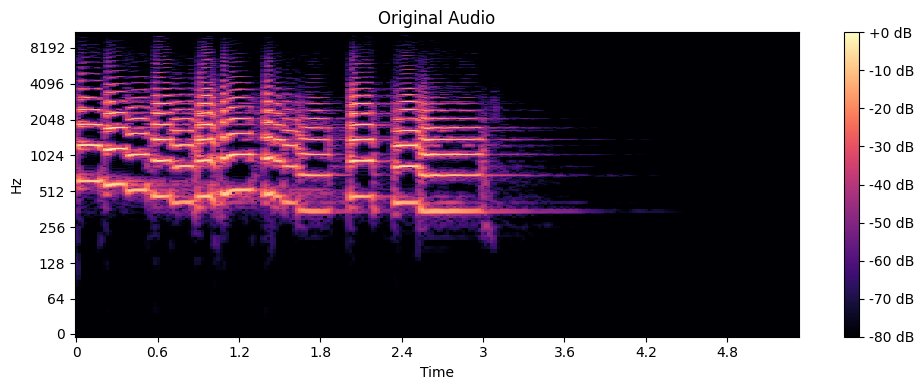

Training PPO agent...
Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 10       |
| time/              |          |
|    fps             | 19       |
|    iterations      | 1        |
|    time_elapsed    | 208      |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10           |
|    ep_rew_mean          | 10           |
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 2            |
|    time_elapsed         | 419          |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0037551522 |
|    clip_fraction        | 0.00989      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_var

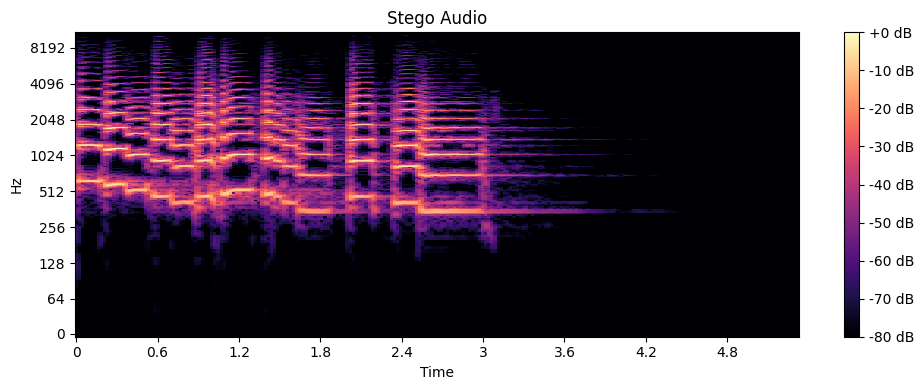

Original Message: There are things that we do not wish to know. and this is a secret I want to send to you okay
Extracted Message: There are things that we do not wish to know. and this is a secret I want to send to you okay
SNR: 126.15 dB


In [ ]:
def train_ppo(audio_path, message, total_timesteps=10000):
    """Train PPO agent for audio steganography"""
    env = make_vec_env(lambda: AudioStegoEnv(audio_path, message), n_envs=4)

    policy_kwargs = dict(
        features_extractor_class=CustomFeatureExtractor,
        features_extractor_kwargs=dict(features_dim=128),
    )

    model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,
                device=device, learning_rate=3e-4, n_steps=1024)
    model.learn(total_timesteps=total_timesteps)

    return model

# Example usage
if __name__ == "__main__":
    # Initialize the framework
    # cfg = Config()
    # framework = RLAudioSteganography(cfg)
   # Load sample audio
    audio_path = librosa.ex('trumpet')
    message = "There are things that we do not wish to know. and this is a secret I want to send to you okay"

    # Initialize components
    preprocessor = AudioPreprocessor(audio_path=audio_path)
    magnitudes, phases = preprocessor.compute_mdct()
    mask = preprocessor.get_non_critical_coeffs(magnitudes)

    # Visualize original audio
    preprocessor.plot_spectrogram("Original Audio")

    # Train steganalysis network
    # Pass the audio length to the SteganalysisCNN constructor
    steganalysis_net = SteganalysisCNN(input_channels=len(preprocessor.audio))
    steganalysis_net.to(device)

    # Train PPO agent
    print("Training PPO agent...")
    model = train_ppo(audio_path, message, total_timesteps=10000)

    # Create stego system
    stego_system = EmbeddingModule(steganalysis_net)

    # Embed message using optimal alpha
    env = AudioStegoEnv(audio_path, message)
    obs = env.reset()
    action, _ = model.predict(obs, deterministic=True)

    modified_magnitudes = stego_system.embed(magnitudes, mask, message, alpha=action[0])
    stego_audio = preprocessor.reconstruct_audio(modified_magnitudes, phases)

    # Save stego audio
    scipy.io.wavfile.write("stego_audio.wav", SAMPLE_RATE, stego_audio)

    # Visualize stego audio
    stego_preprocessor = AudioPreprocessor(audio_data=stego_audio, sr=SAMPLE_RATE)
    stego_preprocessor.plot_spectrogram("Stego Audio")

    # Extract message
    extracted_message = stego_system.extract(modified_magnitudes, mask, len(message))
    print(f"Original Message: {message}")
    print(f"Extracted Message: {extracted_message}")

    # Evaluate performance
    # Ensure both audio arrays have the same length for evaluation
    min_len = min(len(stego_audio), len(preprocessor.audio))
    stego_audio_trimmed = stego_audio[:min_len]
    original_audio_trimmed_eval = preprocessor.audio[:min_len]

    noise = stego_audio_trimmed - original_audio_trimmed_eval
    snr = 10 * np.log10(np.mean(original_audio_trimmed_eval**2) / np.mean(noise**2))
    print(f"SNR: {snr:.2f} dB")

    # detection_prob = stego_system.detect(stego_audio)
    # print(f"Detection Probability: {detection_prob:.4f}")
    # print(f"Undetectability: {100 * (1 - detection_prob):.2f}%")


    # print("RL-based Audio Steganography Framework initialized successfully!")
    # print("To use this framework:")
    # print("1. Prepare WAV audio files for training and testing")
    # print("2. Train the model: framework.train('audio.wav', 'message', num_episodes=100)")
    # print("3. Embed messages: framework.embed_message('input.wav', 'secret', 'output.wav')")
    # print("4. Extract messages: framework.extract_message('output.wav', positions, length)")